In [110]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import KMeans


# Configuration
MAT_DIR = "C:\\Users\\amirr\\Documents\\Postdoc_Lab\\Pub\\plumes\\Plumes20\\all"          # directory containing .mat files
VARIABLE_NAME = "plume"              # preferred dataset name inside .mat files
PEAK_DISTANCE = 0.025*10000           # minimum distance between peaks (10ms) 0.01* 10000Hz sampling rate
PEAK_PROMINENCE = 0.25                # minimum prominence of peaks
THRESHOLD_RATIO = 0.15               # only count peaks above this fraction of max amplitude
NORMALIZE_METHOD = 'minmax'          # 'zscore' or 'minmax' or None
BASELINE_POINTS = 100                # number of initial points to compute baseline
N_CLUSTERS = 2                       # number of clusters (sparse vs. crowded)
OUTPUT_FILE = "peak_clustering_results_20.txt"  # output text file



plume20s_D30_v73_001.mat: detected 73 peaks above 15% of max
plume20s_D30_v73_002.mat: detected 72 peaks above 15% of max
plume20s_D30_v73_003.mat: detected 71 peaks above 15% of max
plume20s_D30_v73_004.mat: detected 77 peaks above 15% of max
plume20s_D30_v73_005.mat: detected 74 peaks above 15% of max
plume20s_D30_v73_006.mat: detected 50 peaks above 15% of max
plume20s_D30_v73_007.mat: detected 71 peaks above 15% of max
plume20s_D30_v73_008.mat: detected 99 peaks above 15% of max
plume20s_D30_v73_009.mat: detected 64 peaks above 15% of max
plume20s_D30_v73_010.mat: detected 55 peaks above 15% of max
plume20s_D30_v73_011.mat: detected 79 peaks above 15% of max
plume20s_D30_v73_012.mat: detected 47 peaks above 15% of max
plume20s_D30_v73_013.mat: detected 80 peaks above 15% of max
plume20s_D30_v73_014.mat: detected 83 peaks above 15% of max
plume20s_D30_v73_015.mat: detected 59 peaks above 15% of max
plume20s_D30_v73_016.mat: detected 65 peaks above 15% of max
plume20s_D30_v73_017.mat

c:\Users\amirr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\amirr\AppData\Local\Temp\ipykernel_30880\3919069869.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  clustered = [(filenames[i], int(peak_counts[i]), label_names[labels[i]]) for i in range(len(filenames))]


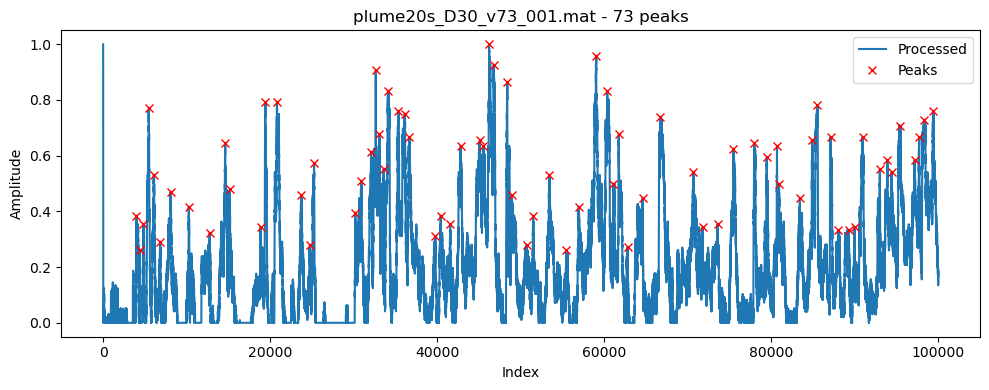

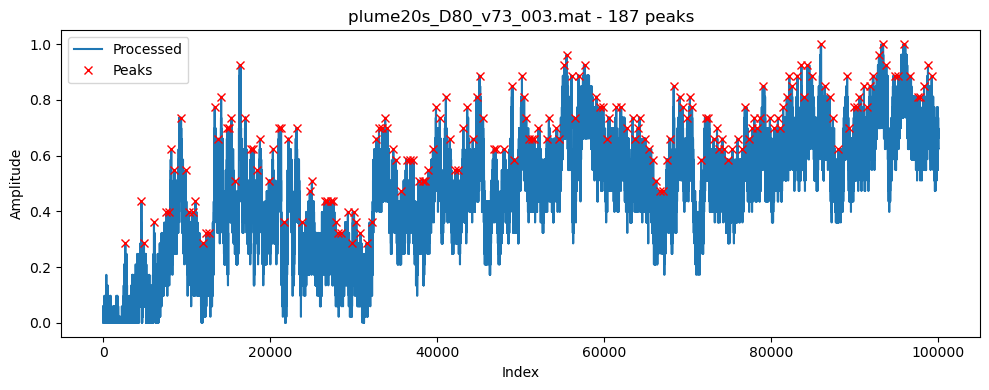

Mean sparse: 78.97
Mean crowded: 197.51
Boundary: 138.24359756097562


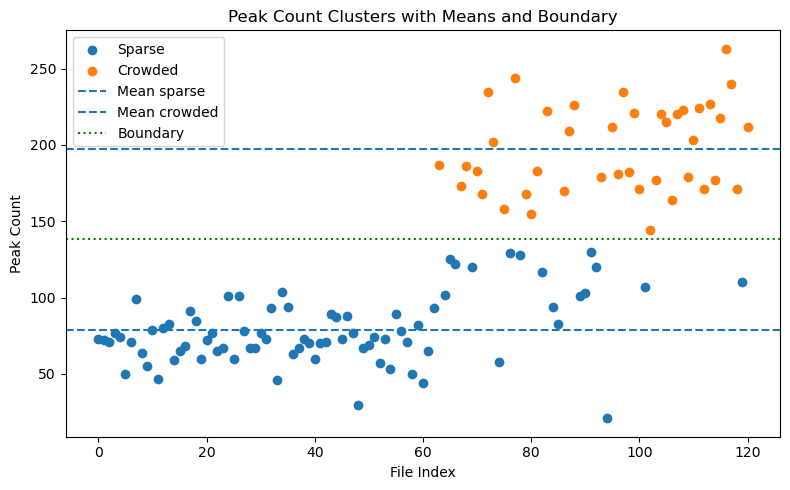

In [111]:
# Baseline correction function
def baseline_correction(data, n_points):
    """
    Subtract the mean of the first n_points from the entire signal,
    so that the baseline starts at zero.
    """
    if data.size < n_points:
        baseline = np.mean(data)
    else:
        baseline = np.mean(data[:n_points])
    return data - baseline

# Normalization function
def normalize(data, method):
    if method == 'zscore':
        mean = np.mean(data)
        std = np.std(data)
        if std == 0:
            return data
        return (data - mean) / std
    elif method == 'minmax':
        min_val = np.min(data)
        max_val = np.max(data)
        if max_val == min_val:
            return data
        return (data - min_val) / (max_val - min_val)
    else:
        return data

# Step 1: Load .mat files, correct baseline, normalize, detect & filter peaks
results = []  # list of tuples: (filename, num_peaks)

for fname in os.listdir(MAT_DIR):
    if not fname.lower().endswith('.mat'):
        continue
    path = os.path.join(MAT_DIR, fname)
    with h5py.File(path, 'r') as f:
        if VARIABLE_NAME in f:
            dname = VARIABLE_NAME
        else:
            keys = list(f.keys())
            if not keys:
                print(f"Warning: no datasets found in {fname}, skipping.")
                continue
            dname = keys[0]
            print(f"Warning: '{VARIABLE_NAME}' not found in {fname}, using '{dname}' instead.")
        data = np.array(f[dname]).squeeze()

    if data.ndim != 1:
        print(f"Warning: loaded data from {fname} is {data.ndim}D, skipping.")
        continue

    # Baseline correction and normalization
    data_base = baseline_correction(data, BASELINE_POINTS)
    data_proc = normalize(data_base, NORMALIZE_METHOD)

    # Detect peaks and filter
    peaks, props = find_peaks(data_proc, distance=PEAK_DISTANCE, prominence=PEAK_PROMINENCE)
    max_amp = np.max(data_proc)
    if max_amp > 0:
        peaks = [p for p in peaks if data_proc[p] >= THRESHOLD_RATIO * max_amp]
    num_peaks = len(peaks)

    results.append((fname, num_peaks))
    print(f"{fname}: detected {num_peaks} peaks above {THRESHOLD_RATIO*100:.0f}% of max")

if not results:
    raise RuntimeError("No valid data processed.")

# Step 2: Cluster by peak counts
filenames = [r[0] for r in results]
peak_counts = np.array([r[1] for r in results]).reshape(-1, 1)
unique_counts = np.unique(peak_counts)

if unique_counts.size < 2:
    labels = np.zeros(len(filenames), dtype=int)
    centroids = np.array([unique_counts[0]])
    label_names = {0: 'sparse'}
else:
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
    labels = kmeans.fit_predict(peak_counts)
    centroids = kmeans.cluster_centers_.flatten()
    order = np.argsort(centroids)
    label_names = {order[i]: name for i, name in enumerate(['sparse','crowded'])}

clustered = [(filenames[i], int(peak_counts[i]), label_names[labels[i]]) for i in range(len(filenames))]

# Step 3: Save results
with open(OUTPUT_FILE, 'w') as f:
    f.write('filename,num_peaks,cluster\n')
    for fname, cnt, grp in clustered:
        f.write(f"{fname},{cnt},{grp}\n")
print(f"Saved results to {OUTPUT_FILE}")

# Step 4: Summaries and example plots
print("\nClustering results:")
for fname, cnt, grp in clustered:
    print(f"{fname}: {cnt} peaks -> {grp}")

# Example raw vs. peaks for sparse and crowded
examples = []
for label in ['sparse','crowded']:
    for fname, _, grp in clustered:
        if grp == label:
            examples.append(fname)
            break
if len(examples) < 2:
    examples = filenames[:2]

for fname in examples:
    path = os.path.join(MAT_DIR, fname)
    with h5py.File(path,'r') as f:
        dname = VARIABLE_NAME if VARIABLE_NAME in f else next(iter(f.keys()))
        data = np.array(f[dname]).squeeze()
    data_proc = normalize(baseline_correction(data, BASELINE_POINTS), NORMALIZE_METHOD)
    peaks, _ = find_peaks(data_proc, distance=PEAK_DISTANCE, prominence=PEAK_PROMINENCE)
    peaks = [p for p in peaks if data_proc[p] >= THRESHOLD_RATIO*np.max(data_proc)]

    plt.figure(figsize=(10,4))
    plt.plot(data_proc, label='Processed')
    plt.plot(peaks, data_proc[peaks], 'rx', label='Peaks')
    plt.title(f"{fname} - {len(peaks)} peaks")
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Step 5: Enhanced clustering plot
# Determine boundary and means
groups = {name: np.array([cnt for _,cnt,grp in clustered if grp==name]) for name in set(label_names.values())}
means = {grp: np.mean(vals) for grp,vals in groups.items()}
boundary = np.mean(list(means.values())) if len(means)>1 else list(means.values())[0]

plt.figure(figsize=(8,5))
for grp, color in [('sparse','blue'),('crowded','red')]:
    idxs = [i for i,(f,_,g) in enumerate(clustered) if g==grp]
    counts = [cnt for _,cnt,g in clustered if g==grp]
    plt.scatter(idxs, counts, label=grp.capitalize())
# Plot centroid lines
for grp,mean in means.items():
    plt.axhline(mean, linestyle='--', label=f"Mean {grp}")
    print(f"Mean {grp}: {mean:.2f}")
# Plot boundary
plt.axhline(boundary, color='green', linestyle=':', label='Boundary')
print(f"Boundary: {boundary}")

plt.xlabel('File Index')
plt.ylabel('Peak Count')
plt.title('Peak Count Clusters with Means and Boundary')
plt.legend()
plt.tight_layout()
plt.show()
